## Explore and Calculate Metrics

Here we calculate metrics for final post-processed boxes and can look at how those metrics change with other steps in the post processing, if you want to.

In [1]:
# which metric file?
#binary_dirs = 'binaries_model1/'
binary_dirs = 'binaries_model4/'

How do we want to quantify how well we are doing?

In [2]:
n_folds_cv = 5 # for calculating the spread in our metrics, we we'll do a CV
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

In [3]:
import pickle
import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe

In [4]:
# build up filename
pp = config.metric_results_dir
pp += binary_dirs.split('/')[0]
pp += '.pickle'
with open(pp, 'rb') as ff:
    icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImage,LABELS,boxes1, scores1, labels1 = pickle.load(ff)

Final box analytics:

In [5]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv)

In [6]:
TPv.shape

(4, 3, 8, 5)

Shape is: (# labels, #scores, #ious, #CV folds)

Calculate precision, recall, F1 (ignore /0 warnings, taken care of):

In [7]:
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

Plot and check it out!

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


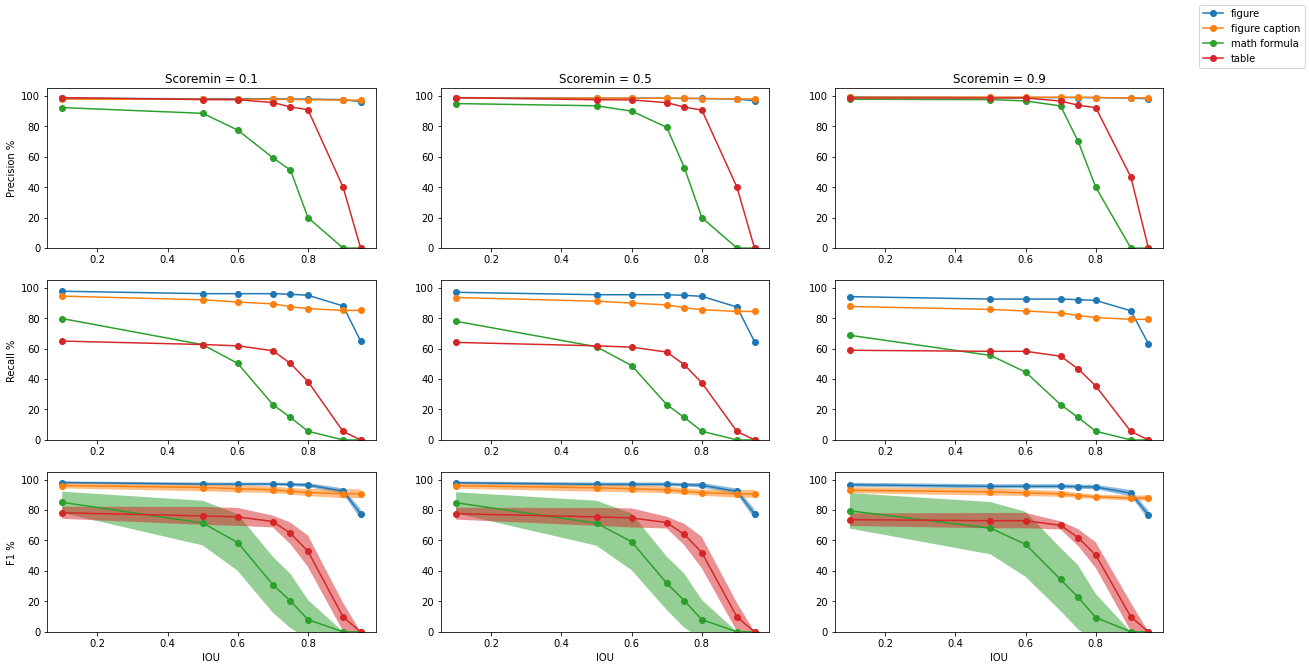

In [8]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

Choose a score cut-off.  For the most part, we've found 0.1 to be fine:

In [9]:
scoremin = 0.1 

What IOU cut-offs for each label? for reference:

In [10]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [11]:
ioumin_per_label = [0.9, 0.95, 0.8, 0.8] # fig, fig+caption, math formula, table

In [12]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

In [13]:
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

In [14]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              87.9%           85.0%           6.1%            36.6%          
FP              2.4%            2.6%            16.7%           3.6%           
FN              12.1%           15.0%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.3+/-1.5%     96.9+/-2.1%     28.4+/-37.0%    91.3+/-7.7%    
Recall          88.1+/-2.3%     84.9+/-2.3%     8.9+/-9.8%      37.2+/-7.4%    
F1              92.4+/-0.7%     90.5+/-2.1%     13.0+/-15.0%    52.6+/-8.2%    


## Vs. Time
Also, let's plot metrics vs. year.

In [15]:
# pick a min score and a min IOU
scoremin = 0.1
ioumin = 0.8

In [16]:
df = get_years_dataframe(imgs_name,scoremin,ioumin,LABELS,
                       truebox3,boxes_sq5,labels_sq5,scores_sq5)

In [17]:
df.head()

,years,total:figure,total:figure caption,total:math formula,total:table,TP:figure,TP:figure caption,TP:math formula,TP:table,FP:figure,FP:figure caption,FP:math formula,FP:table,FN:figure,FN:figure caption,FN:math formula,FN:table
0,1898-01-01,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1907-01-01,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1908-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1909-01-01,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1913-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
sampleHist = '10Y' # 5 years

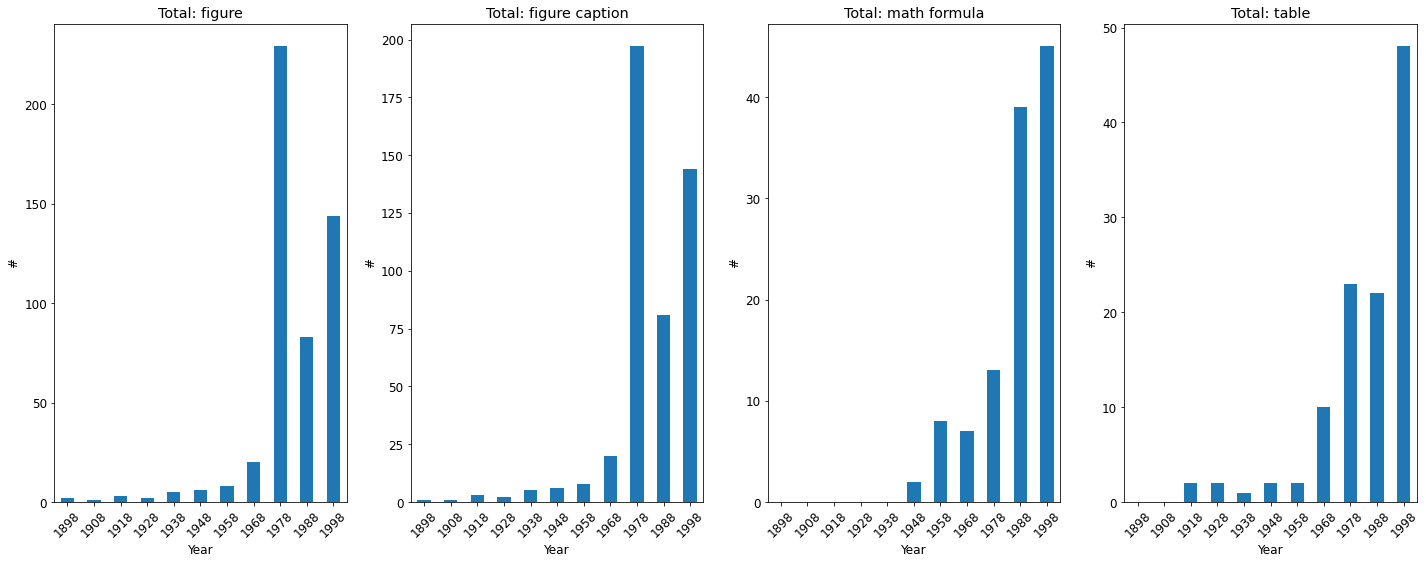

In [19]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['total:'+l])).resample(sampleHist).sum()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Total: ' + l)
    ax[il].set_ylabel('#')
    ax[il].set_xlabel('Year')
#plt.show()

plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_articles_per_year.png')

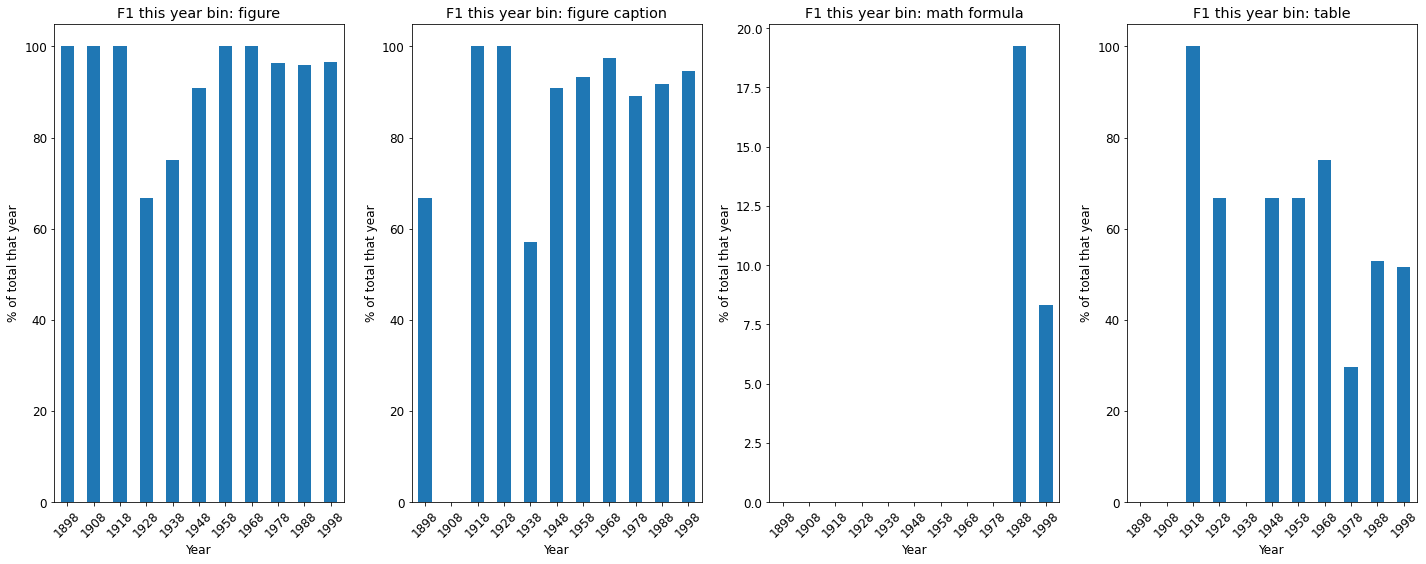

In [20]:
# loop and plot
qname = 'F1:'
bname = 'total:'
qlabel = 'F1'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    tp = pd.Series(index=df['years'],data=np.array(df['TP:'+l])).resample(sampleHist).sum()
    fp = pd.Series(index=df['years'],data=np.array(df['FP:'+l])).resample(sampleHist).sum()
    fn = pd.Series(index=df['years'],data=np.array(df['FN:'+l])).resample(sampleHist).sum()
    p = tp/(tp+fp); r = tp/(tp+fn)
    quant = 100*(2.0*r*p)/(r+p)
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' this year bin: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

Some other metrics:

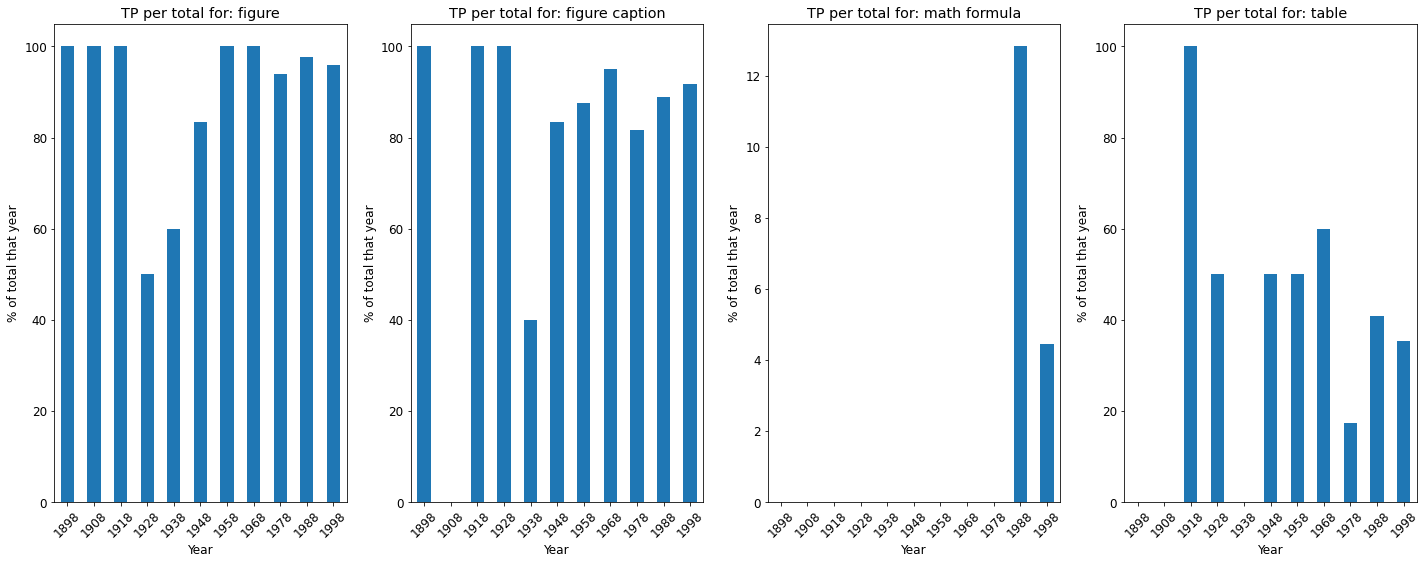

In [21]:
# loop and plot
qname = 'TP:'
bname = 'total:'
qlabel = 'TP'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
#plt.show()
plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_truePositives_per_year.png')

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


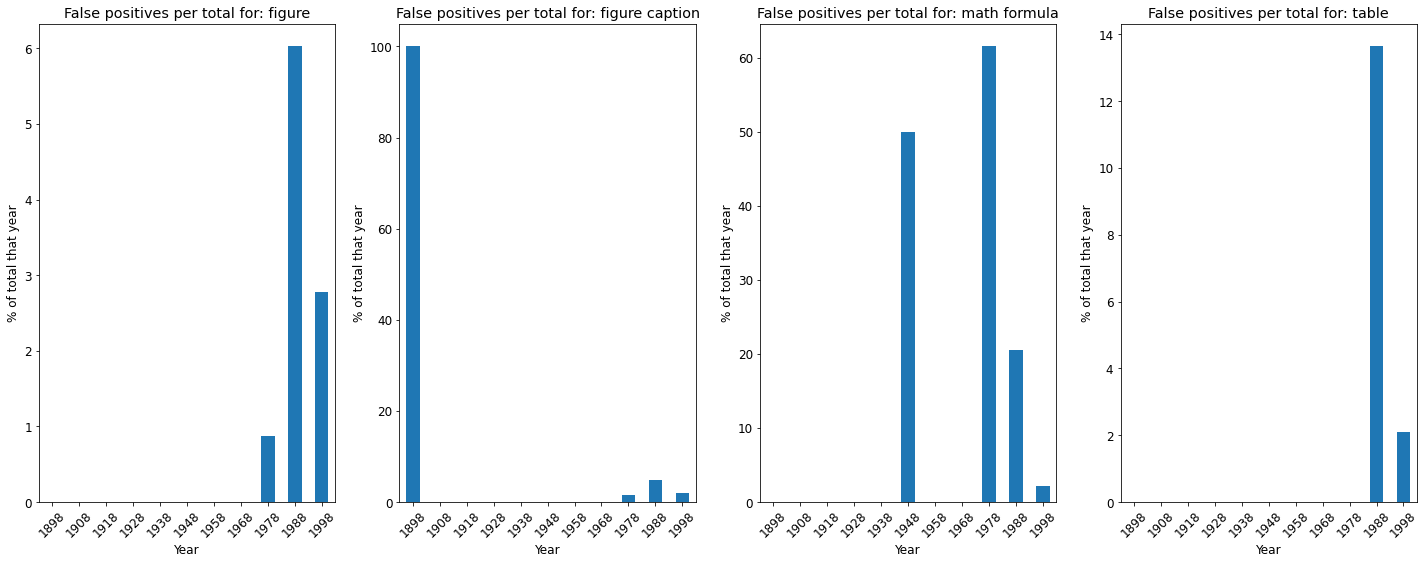

In [22]:
# loop and plot
qname = 'FP:'
bname = 'total:'
qlabel = 'False positives'
#fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

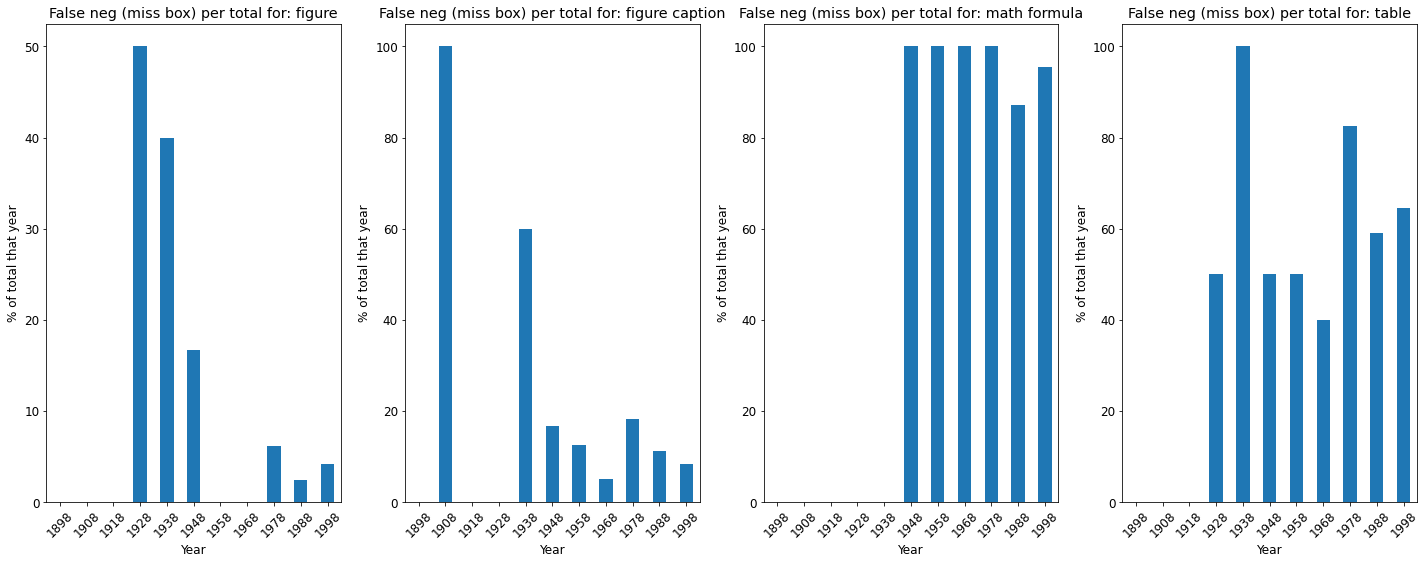

In [23]:
# loop and plot
qname = 'FN:'
bname = 'total:'
qlabel = 'False neg (miss box)'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

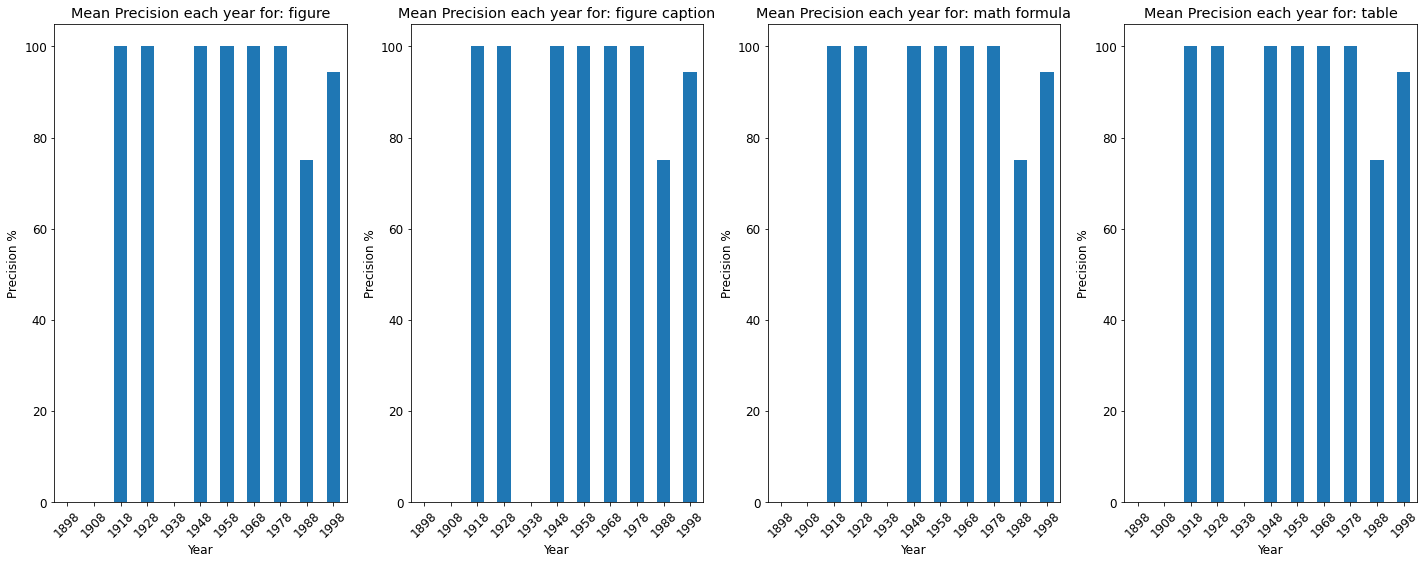

In [24]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    p = tp/(tp+fp); 
    quant = 100*p
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Precision each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

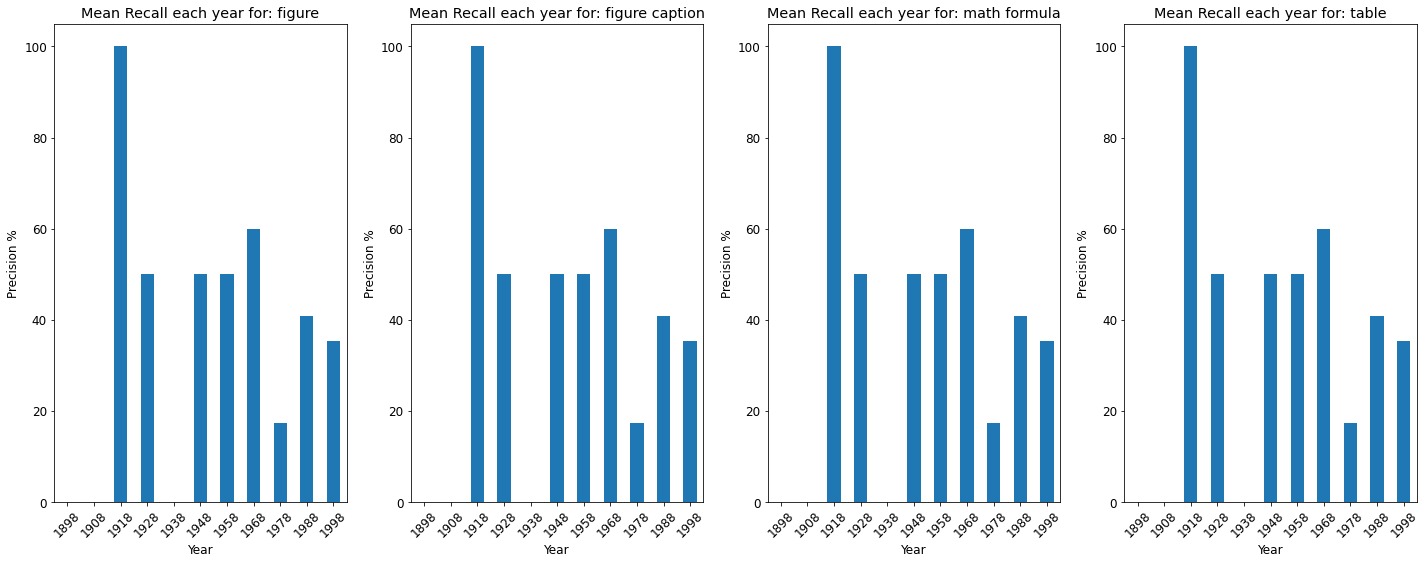

In [25]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    r = tp/(tp+fn)
    quant = 100*r
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Recall each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

# Other steps of the post processing process

## 1. Raw-ish boxes

These have been cleaned for overlapping boxes -- only the higher score ones are taken if there is a large overlap.

Final metrics:

In [26]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              truebox,sboxes_cleaned, slabels_cleaned, sscores_cleaned,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

In [27]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              60.2%           0.6%            6.1%            36.6%          
FP              4.2%            7.9%            16.7%           3.6%           
FN              39.8%           99.4%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       93.5+/-1.9%     11.2+/-10.2%    11.1+/-14.1%    91.0+/-11.1%   
Recall          60.5+/-3.1%     0.6+/-0.5%      4.3+/-5.8%      34.2+/-14.9%   
F1              73.4+/-2.5%     1.1+/-0.9%      6.2+/-8.2%      47.7+/-16.7%   


IOU=0.6

In [28]:
#ioumin_per_label2 = [0.6,0.6,0.6,0.6]

ioumin_per_label2 = [0.8,0.8,0.8,0.8]

In [29]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,sboxes_cleaned, slabels_cleaned, sscores_cleaned,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           35.9%           6.1%            36.6%          
FP              2.2%            6.2%            16.7%           3.6%           
FN              10.1%           64.1%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.6+/-1.5%     84.8+/-9.1%     11.1+/-14.1%    91.0+/-11.1%   
Recall          90.0+/-4.4%     35.6+/-4.3%     4.3+/-5.8%      34.2+/-14.9%   
F1              93.6+/-2.6%     50.0+/-5.4%     6.2+/-8.2%      47.7+/-16.7%   


Plot vs IOU:

In [30]:
iouvec = [0.05, 0.1,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95]
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              sboxes_cleaned, slabels_cleaned, sscores_cleaned,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


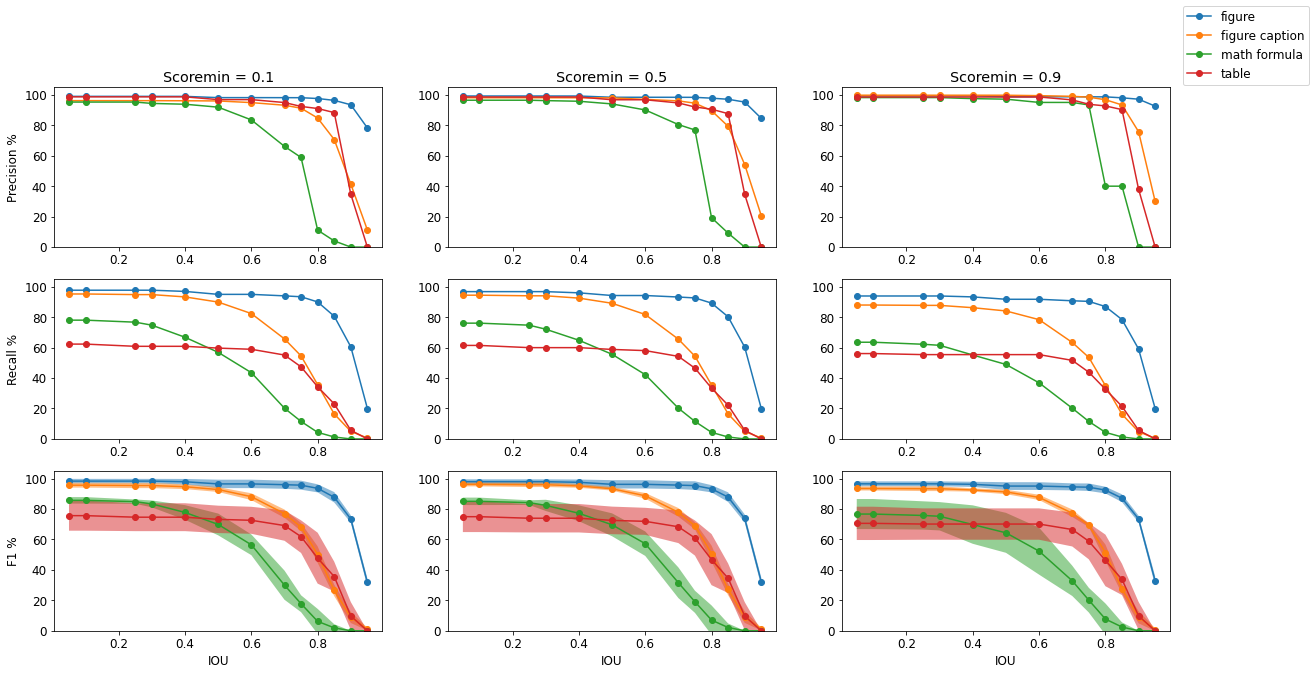

In [31]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## 2. Merge with PDF results

If any pdffigures2 results -- get these.

In [32]:
#boxes_pdf, labels_pdf, scores_pdf
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_pdf, labels_pdf, scores_pdf,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           40.1%           6.1%            36.6%          
FP              2.2%            5.9%            16.7%           3.6%           
FN              10.1%           59.9%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.6+/-1.5%     86.5+/-8.4%     11.1+/-14.1%    91.0+/-11.1%   
Recall          90.0+/-4.4%     39.8+/-3.6%     4.3+/-5.8%      33.8+/-17.8%   
F1              93.6+/-2.6%     54.5+/-4.8%     6.2+/-8.2%      46.3+/-20.8%   


In [33]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_pdf, labels_pdf, scores_pdf,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


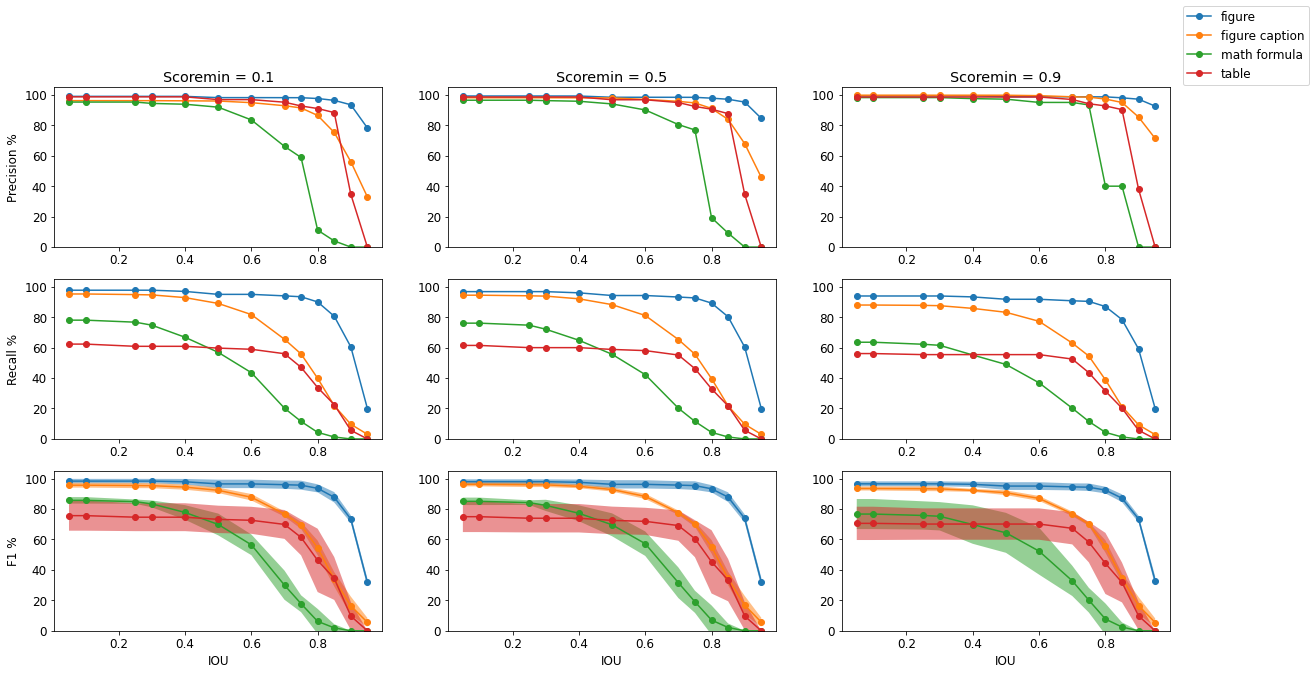

In [34]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Merge with Heuristics

If there are also heurstically found figure captions -- overlap these boxes.

In [35]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_heur, labels_heur, scores_heur,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           59.9%           6.1%            36.6%          
FP              2.2%            5.3%            16.7%           3.6%           
FN              10.1%           40.1%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.6+/-1.5%     91.5+/-6.2%     11.1+/-14.1%    91.0+/-11.1%   
Recall          90.0+/-4.4%     59.8+/-2.3%     4.3+/-5.8%      33.8+/-17.8%   
F1              93.6+/-2.6%     72.2+/-3.1%     6.2+/-8.2%      46.3+/-20.8%   


In [36]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_heur, labels_heur, scores_heur,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


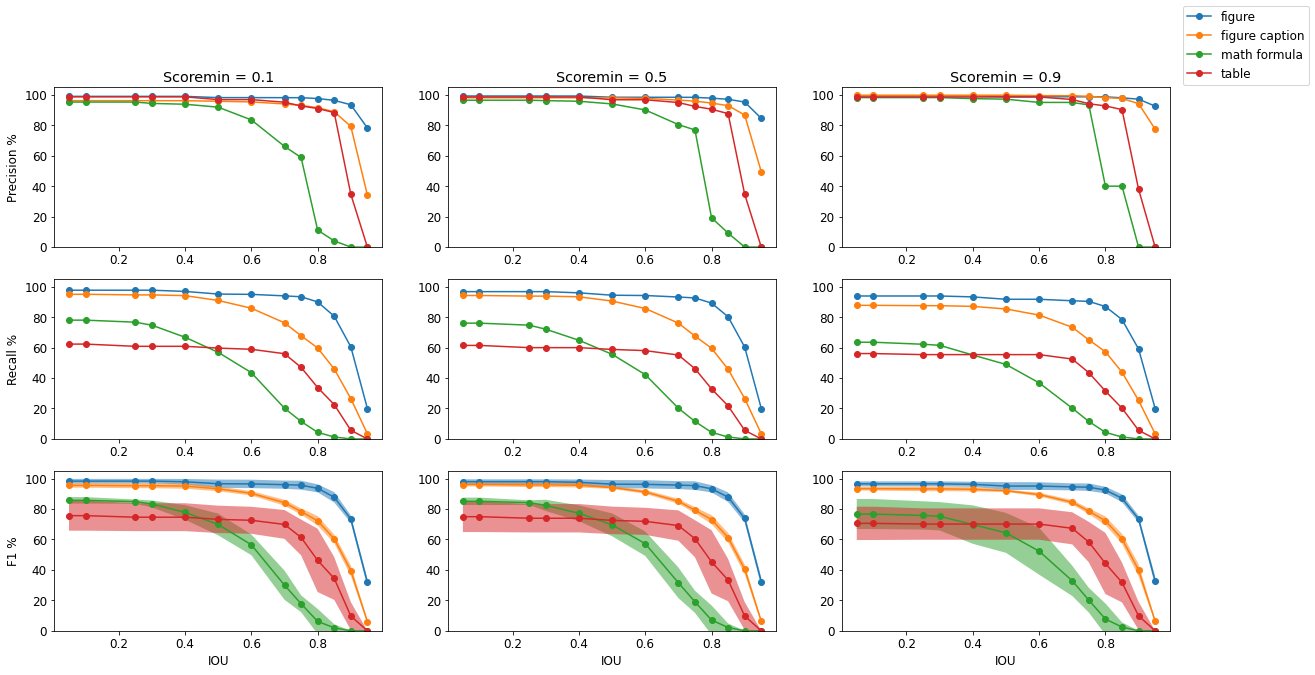

In [37]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Add in Heuristic Captions

If there are figures without captions, look for heurstically determined captions.

In [38]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_heur2, labels_heur2, scores_heur2,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           61.4%           6.1%            36.6%          
FP              4.2%            53.7%           31.6%           12.5%          
FN              10.1%           38.6%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       95.5+/-1.3%     53.2+/-2.6%     9.5+/-12.2%     65.8+/-19.8%   
Recall          90.0+/-4.4%     61.2+/-3.1%     4.3+/-5.8%      33.8+/-17.8%   
F1              92.6+/-2.9%     56.9+/-2.0%     5.9+/-7.9%      43.8+/-20.6%   


In [39]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_heur2, labels_heur2, scores_heur2,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


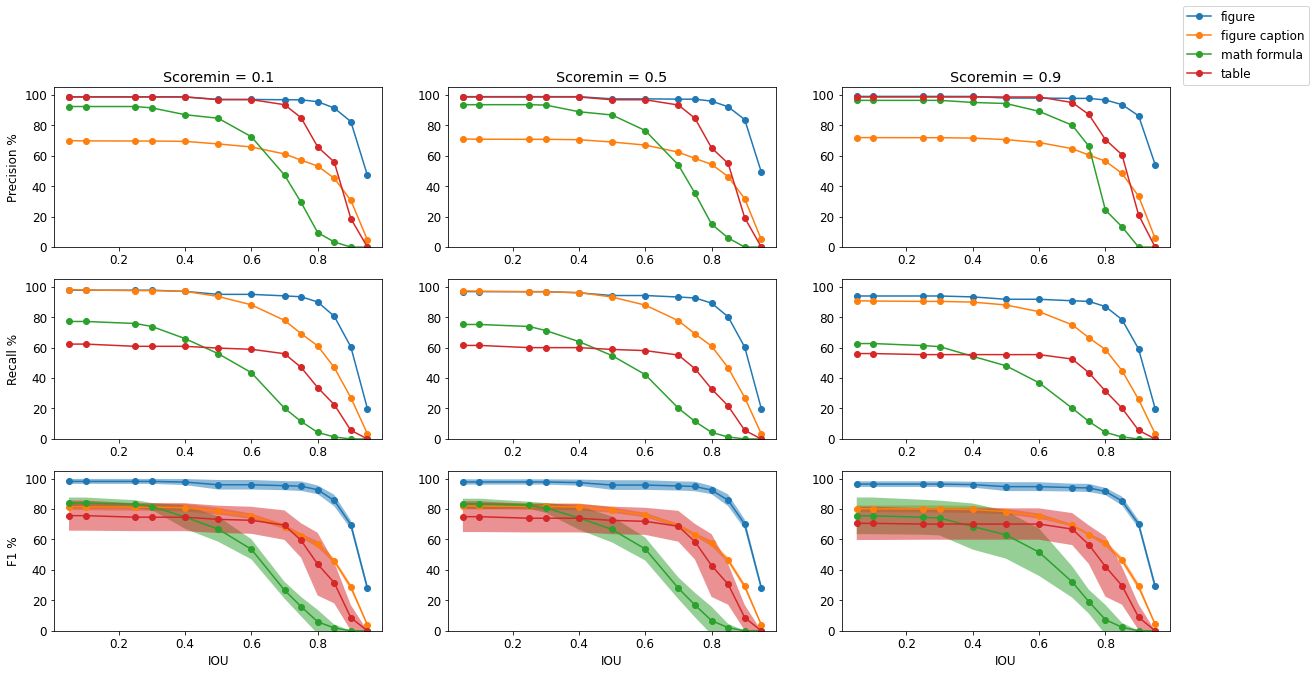

In [40]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Expand by paragraphs and words

### 1. Found boxes

In [41]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           86.2%           6.1%            36.6%          
FP              2.2%            3.8%            16.7%           3.6%           
FN              10.1%           13.8%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.6+/-1.5%     95.6+/-3.8%     11.1+/-14.1%    91.0+/-11.1%   
Recall          90.0+/-4.4%     86.3+/-2.0%     4.3+/-5.8%      33.8+/-17.8%   
F1              93.6+/-2.6%     90.6+/-2.0%     6.2+/-8.2%      46.3+/-20.8%   


In [42]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


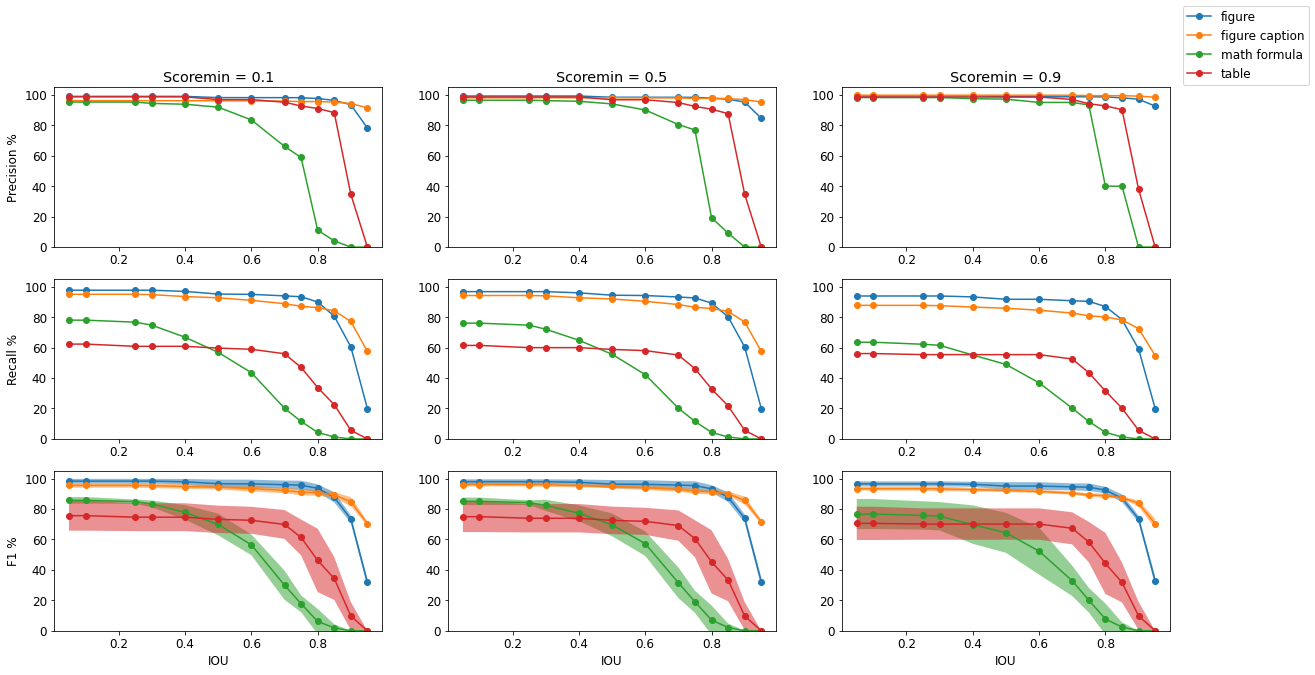

In [43]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

### 2. Expand trues as well -- this is technically already done in annotations? or no?

In [44]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           86.8%           6.1%            36.6%          
FP              2.2%            3.8%            16.7%           3.6%           
FN              10.1%           13.2%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.6+/-1.5%     95.6+/-3.7%     11.1+/-14.1%    91.0+/-11.1%   
Recall          90.0+/-4.4%     87.0+/-2.2%     4.3+/-5.8%      33.8+/-17.8%   
F1              93.6+/-2.6%     91.0+/-1.6%     6.2+/-8.2%      46.3+/-20.8%   


In [45]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


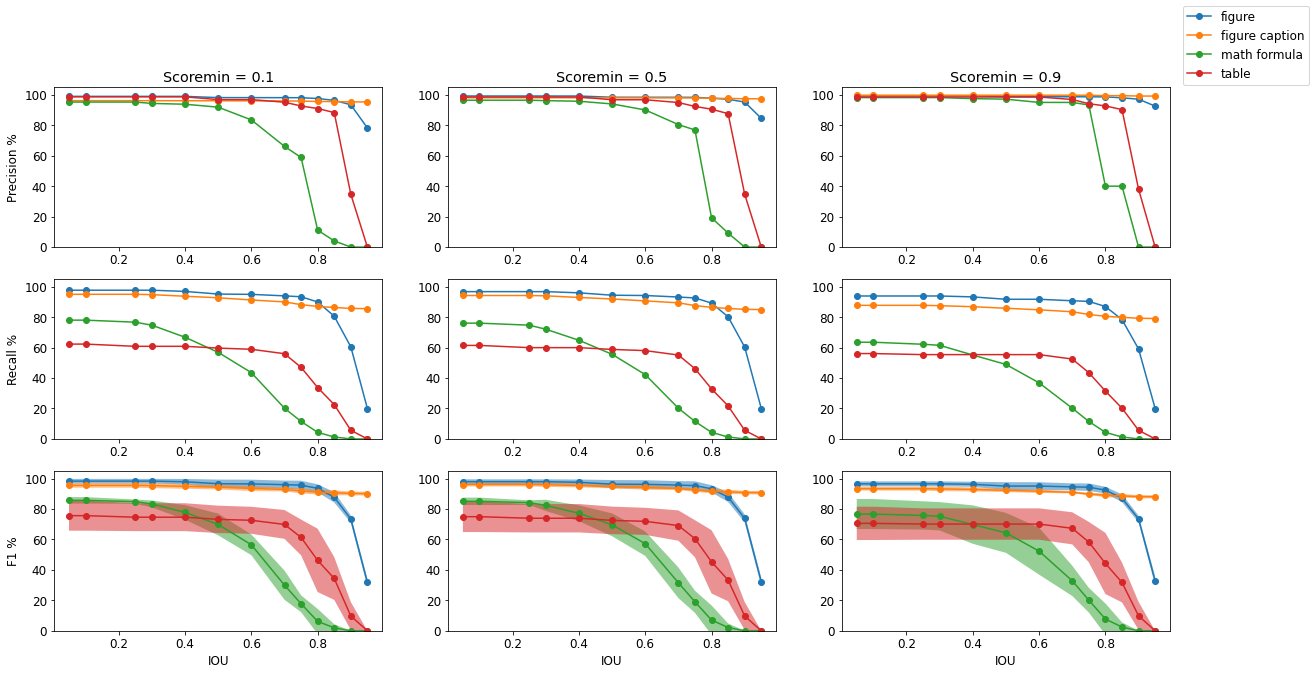

In [46]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Merge with Image Processing Squares

In [47]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_sq1, labels_sq1, scores_sq1,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           86.8%           6.1%            36.6%          
FP              2.2%            3.8%            16.7%           3.6%           
FN              10.1%           13.2%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.6+/-1.1%     95.6+/-3.7%     11.1+/-14.1%    91.0+/-11.1%   
Recall          90.0+/-3.6%     87.0+/-2.2%     4.3+/-5.8%      33.8+/-17.8%   
F1              93.6+/-2.1%     91.0+/-1.6%     6.2+/-8.2%      46.3+/-20.8%   


In [48]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_sq1, labels_sq1, scores_sq1,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


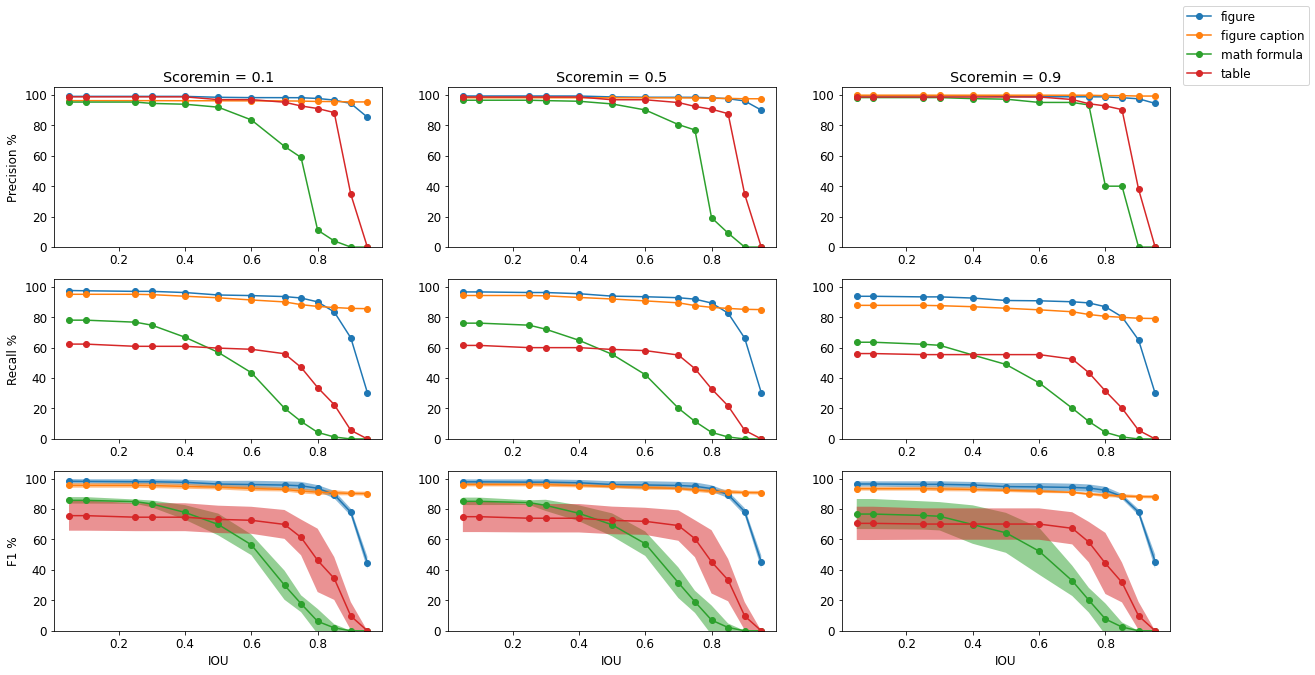

In [49]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Drop any very large captions

In [50]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_sq2, labels_sq2, scores_sq2,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           86.8%           6.1%            36.6%          
FP              2.2%            3.8%            16.7%           3.6%           
FN              10.1%           13.2%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.6+/-1.1%     95.6+/-3.7%     11.1+/-14.1%    91.0+/-11.1%   
Recall          90.0+/-3.6%     87.0+/-2.2%     4.3+/-5.8%      33.8+/-17.8%   
F1              93.6+/-2.1%     91.0+/-1.6%     6.2+/-8.2%      46.3+/-20.8%   


In [51]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_sq2, labels_sq2, scores_sq2,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


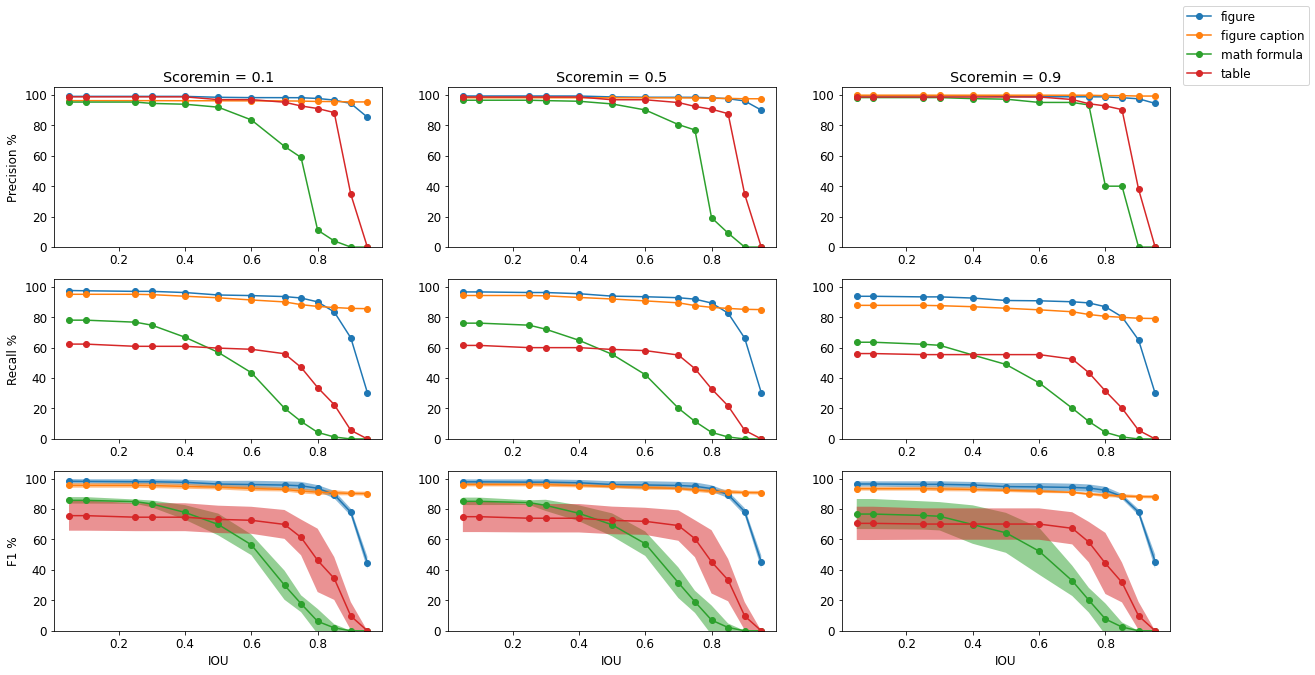

In [52]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Take out caption overlap with fig boxes -- why does this go back to table/math formula levels from before?

### 1. Found boxes

In [53]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              91.1%           85.1%           6.1%            36.6%          
FP              2.6%            2.3%            16.7%           3.6%           
FN              8.9%            14.9%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.2+/-1.3%     97.2+/-1.1%     11.1+/-14.1%    91.0+/-11.1%   
Recall          91.2+/-3.8%     85.3+/-1.9%     4.3+/-5.8%      33.8+/-17.8%   
F1              94.1+/-2.6%     90.8+/-1.2%     6.2+/-8.2%      46.3+/-20.8%   


In [54]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


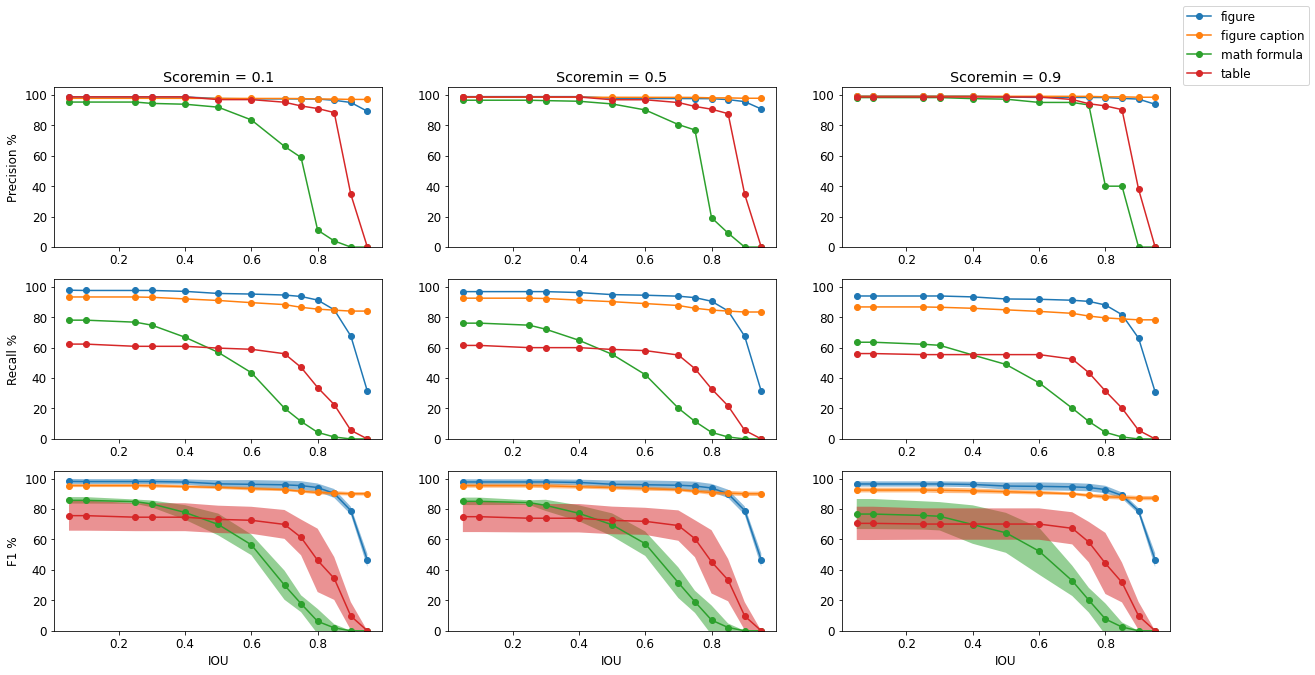

In [55]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

### 2. True boxes

In [56]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox2,boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              90.3%           86.3%           6.1%            36.6%          
FP              2.6%            2.4%            16.7%           3.6%           
FN              9.7%            13.7%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.2+/-1.4%     97.3+/-1.1%     11.1+/-14.1%    91.0+/-11.1%   
Recall          90.5+/-4.4%     86.5+/-2.0%     4.3+/-5.8%      33.8+/-17.8%   
F1              93.7+/-2.9%     91.6+/-1.0%     6.2+/-8.2%      46.3+/-20.8%   


In [57]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox2,
                                              boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


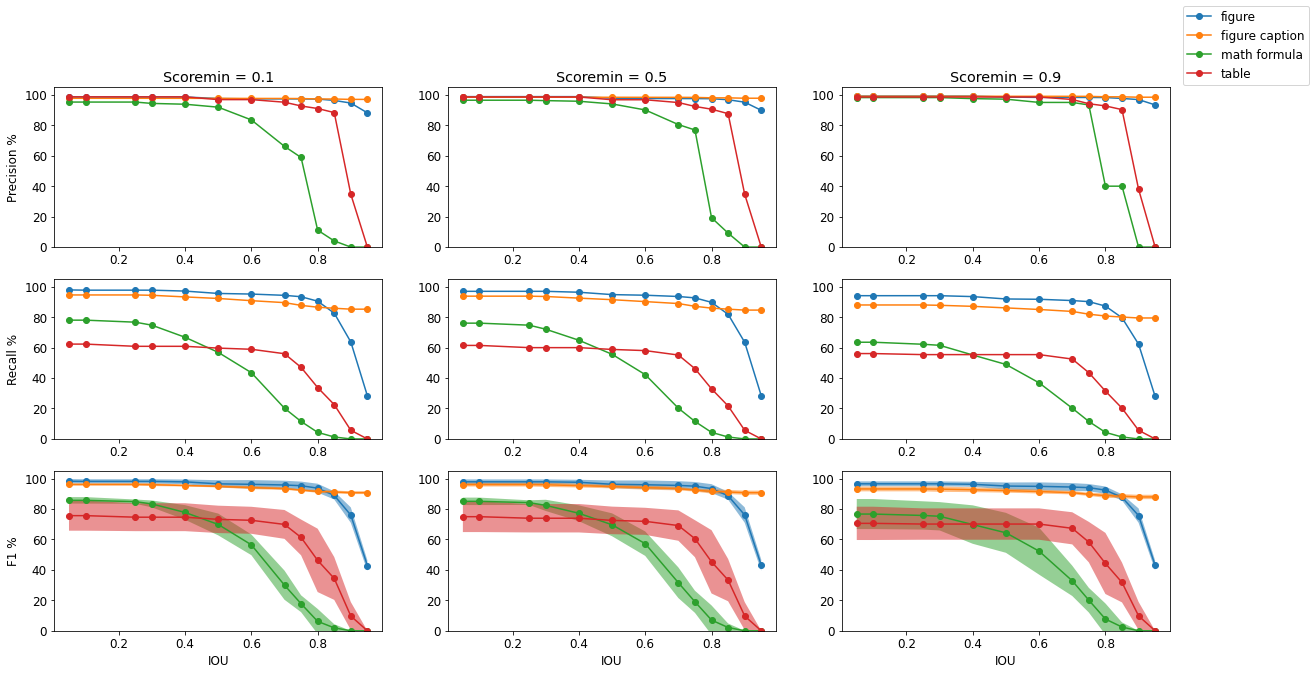

In [58]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Expand again for some reason??

In [59]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox2,boxes_sq4, labels_sq4, scores_sq4,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              93.4%           86.3%           6.1%            36.6%          
FP              2.2%            2.4%            16.7%           3.6%           
FN              6.6%            13.7%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.7+/-1.1%     97.3+/-1.1%     11.1+/-14.1%    91.0+/-11.1%   
Recall          93.5+/-3.4%     86.5+/-2.0%     4.3+/-5.8%      33.8+/-17.8%   
F1              95.5+/-2.1%     91.6+/-1.0%     6.2+/-8.2%      46.3+/-20.8%   


In [60]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox2,
                                              boxes_sq4, labels_sq4, scores_sq4,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


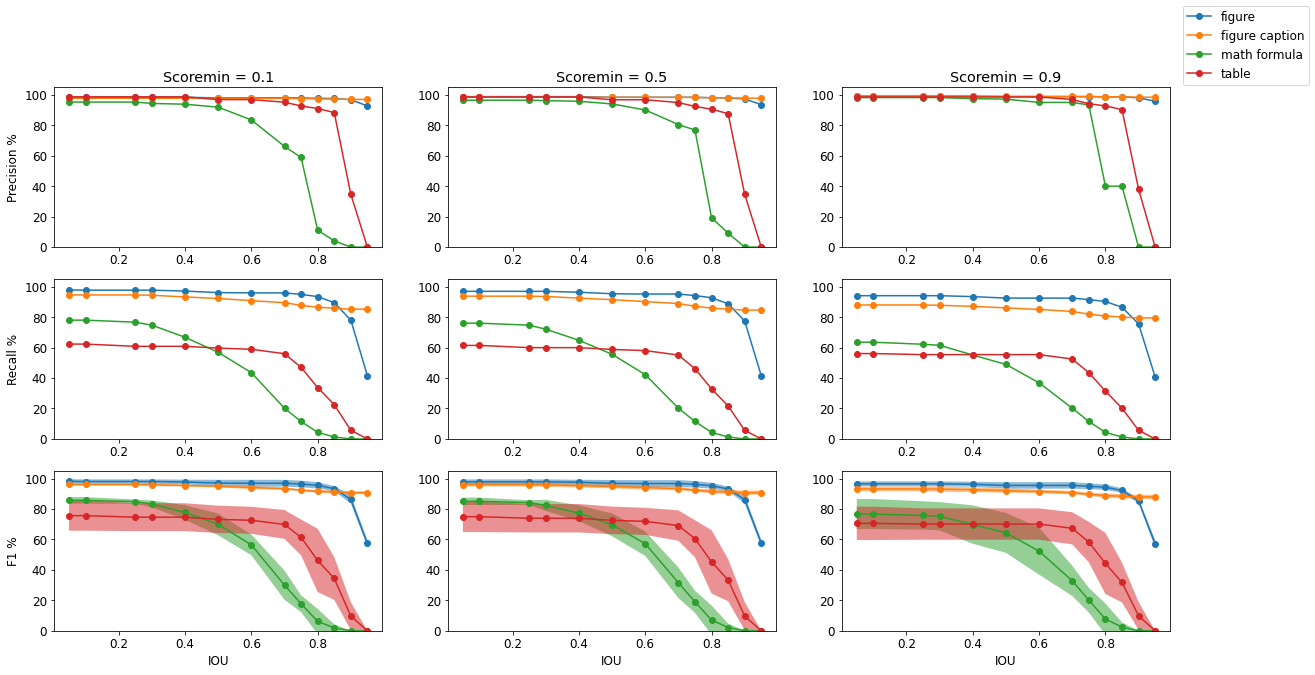

In [61]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Expand Area Above Captions

### 1. Found boxes

In [62]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox2,boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              79.9%           86.3%           6.1%            36.6%          
FP              2.8%            2.4%            16.7%           3.6%           
FN              20.1%           13.7%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       96.6+/-0.9%     97.3+/-1.1%     11.1+/-14.1%    91.0+/-11.1%   
Recall          79.8+/-1.8%     86.5+/-2.0%     4.3+/-5.8%      33.8+/-17.8%   
F1              87.4+/-1.4%     91.6+/-1.0%     6.2+/-8.2%      46.3+/-20.8%   


In [63]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox2,
                                              boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


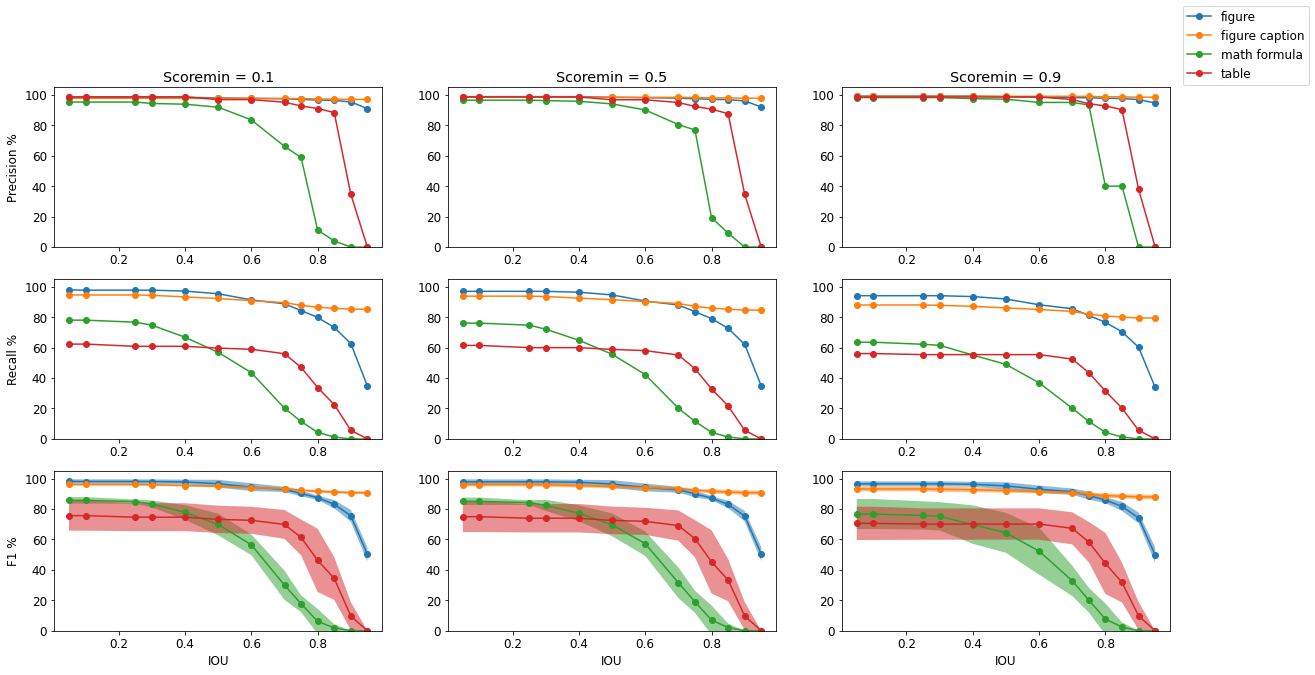

In [64]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

### 2. True Boxes

In [65]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox3,boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              94.8%           86.3%           6.1%            36.6%          
FP              2.2%            2.4%            16.7%           3.6%           
FN              5.2%            13.7%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       97.7+/-1.0%     97.3+/-1.1%     11.1+/-14.1%    91.0+/-11.1%   
Recall          94.8+/-2.9%     86.5+/-2.0%     4.3+/-5.8%      33.8+/-17.8%   
F1              96.2+/-1.7%     91.6+/-1.0%     6.2+/-8.2%      46.3+/-20.8%   


In [66]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox3,
                                              boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


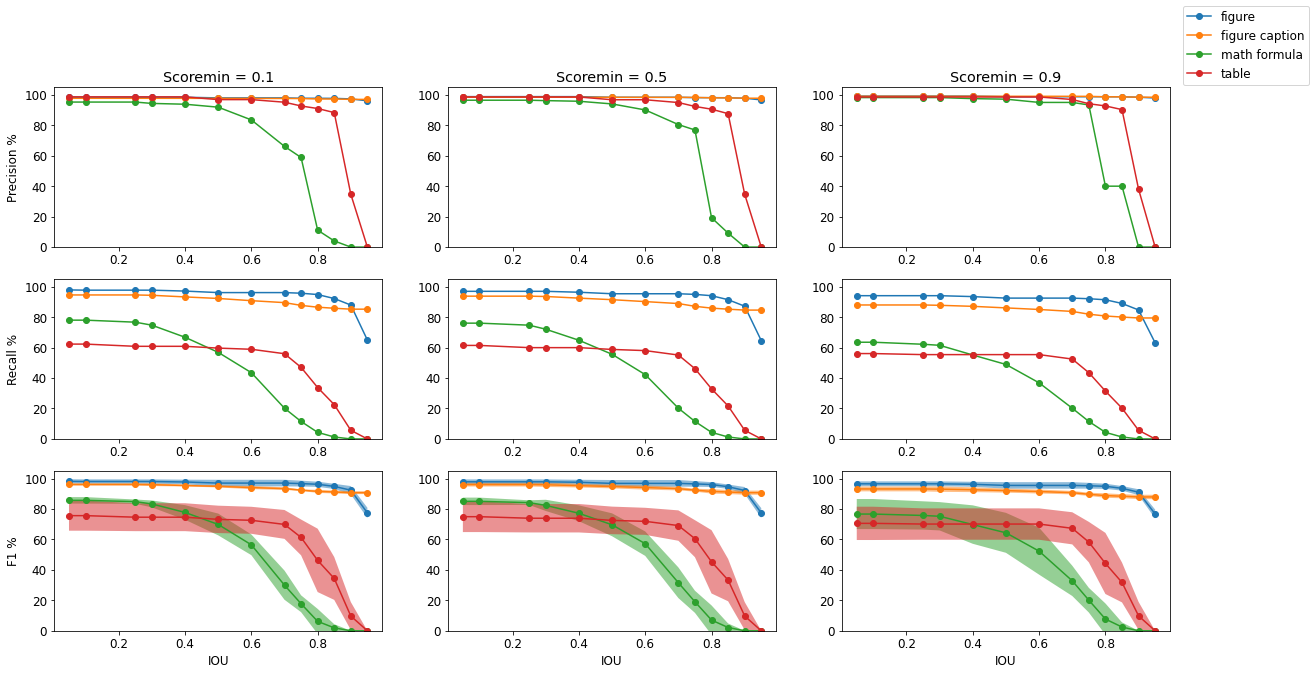

In [67]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Plot how metrics change with steps

In [68]:
iouvec2 = [0.05, 0.1, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]

In [69]:
# trueboxes = [truebox,truebox,truebox,truebox,truebox,truebox1,truebox1,
#              truebox1,truebox1,truebox2,truebox2,truebox2,truebox3]
# foundboxes = [sboxes_cleaned,boxes_pdf,boxes_heur,boxes_heur2,boxes_par_found,
#               boxes_par_found,boxes_sq1,boxes_sq2,boxes_sq3,boxes_sq3,boxes_sq4,boxes_sq5,boxes_sq5]
# foundlabels=[slabels_cleaned,labels_pdf,labels_heur,labels_heur2,labels_par_found,labels_par_found,
#              labels_sq1,labels_sq2,labels_sq3,labels_sq3,labels_sq4,labels_sq5,labels_sq5]
# foundscores=[sscores_cleaned,scores_pdf,scores_heur,scores_heur2,scores_par_found,scores_par_found,
#              scores_sq1,scores_sq2,scores_sq3,scores_sq3,scores_sq4,scores_sq5,scores_sq5]


# # actual things
# trueboxes = [truebox, #1
#              truebox, #2
#              truebox, #3
#              truebox, #4
#              truebox1, #5
#              truebox1, #6
#              truebox2, #7
#              truebox3] #8
# foundboxes = [sboxes_cleaned, #1
#               boxes_pdf, #2
#               boxes_heur, #3
#               boxes_heur2, #4 --
#               boxes_sq1, #5
#               boxes_sq2, #6 --
#               boxes_sq4, #7
#               boxes_sq5] #8
# foundlabels=[slabels_cleaned,labels_pdf,labels_heur,labels_heur2,labels_sq1,labels_sq2,labels_sq4,labels_sq5]
# foundscores=[sscores_cleaned,scores_pdf,scores_heur,scores_heur2,scores_sq1,scores_sq2,scores_sq4,scores_sq5]


# paper order?
trueboxes = [truebox, #1
             truebox, #2
             truebox, #3
             truebox, #4
             truebox]#, #4
             # truebox1, #5
             # truebox1, #6
             # truebox2, #7
             # truebox3] #8
foundboxes = [boxes1,
              sboxes_cleaned, #1
              boxes_pdf, #2
              boxes_heur,
              boxes_heur2]#, #3
              # boxes_par_found, 
              # boxes_sq2, #6 --
              # boxes_sq4, #7
              # boxes_sq5] #8
foundlabels=[labels1, 
             slabels_cleaned,
             labels_pdf,
             labels_heur,
            labels_heur2]#,
             # labels_par_found,
             # labels_sq2,
             # labels_sq4,
             # labels_sq5]
foundscores=[scores1,
             sscores_cleaned,
             scores_pdf,
             scores_heur,
            scores_heur2]#,
             # scores_par_found,
             # scores_sq2,
             # scores_sq4,
             # scores_sq5]

In [70]:
len(trueboxes), len(foundboxes), len(foundlabels), len(foundscores)

(5, 5, 5, 5)

In [71]:
#precsave[0]

In [72]:
precsave = []; recsave = []; f1save = []
TPsave = []; FPsave = []; FNsave = []

for t,fb,fl,fs in zip(trueboxes, foundboxes, foundlabels, foundscores):
    TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],iouvec2,
                                                  t,fb, fl, fs,n_folds_cv=n_folds_cv,seed=5)
    # combo metrics
    precisions, precision_stds, recalls, \
      recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                                   LABELS,[scoremin],
                                                   iouvec2)

    TPsave.append(TPs[:,0,:].sum(axis=-1)); FPsave.append(FPs[:,0,:].sum(axis=-1)); FNsave.append(FNs[:,0,:].sum(axis=-1))
    precsave.append(precisions[:,0,:]); recsave.append(recalls[:,0,:]); f1save.append(f1s[:,0,:])
    #import sys; sys.exit()

In [73]:
#labels1
np.array(TPsave).shape, TPs.shape

((5, 4, 18), (4, 1, 18, 5))

In [74]:
n = len(foundboxes)+3
colors = plt.cm.jet(np.linspace(0,1,n))
ylabels = ['TP','FP','FN','Precision', 'Recall', 'F1']

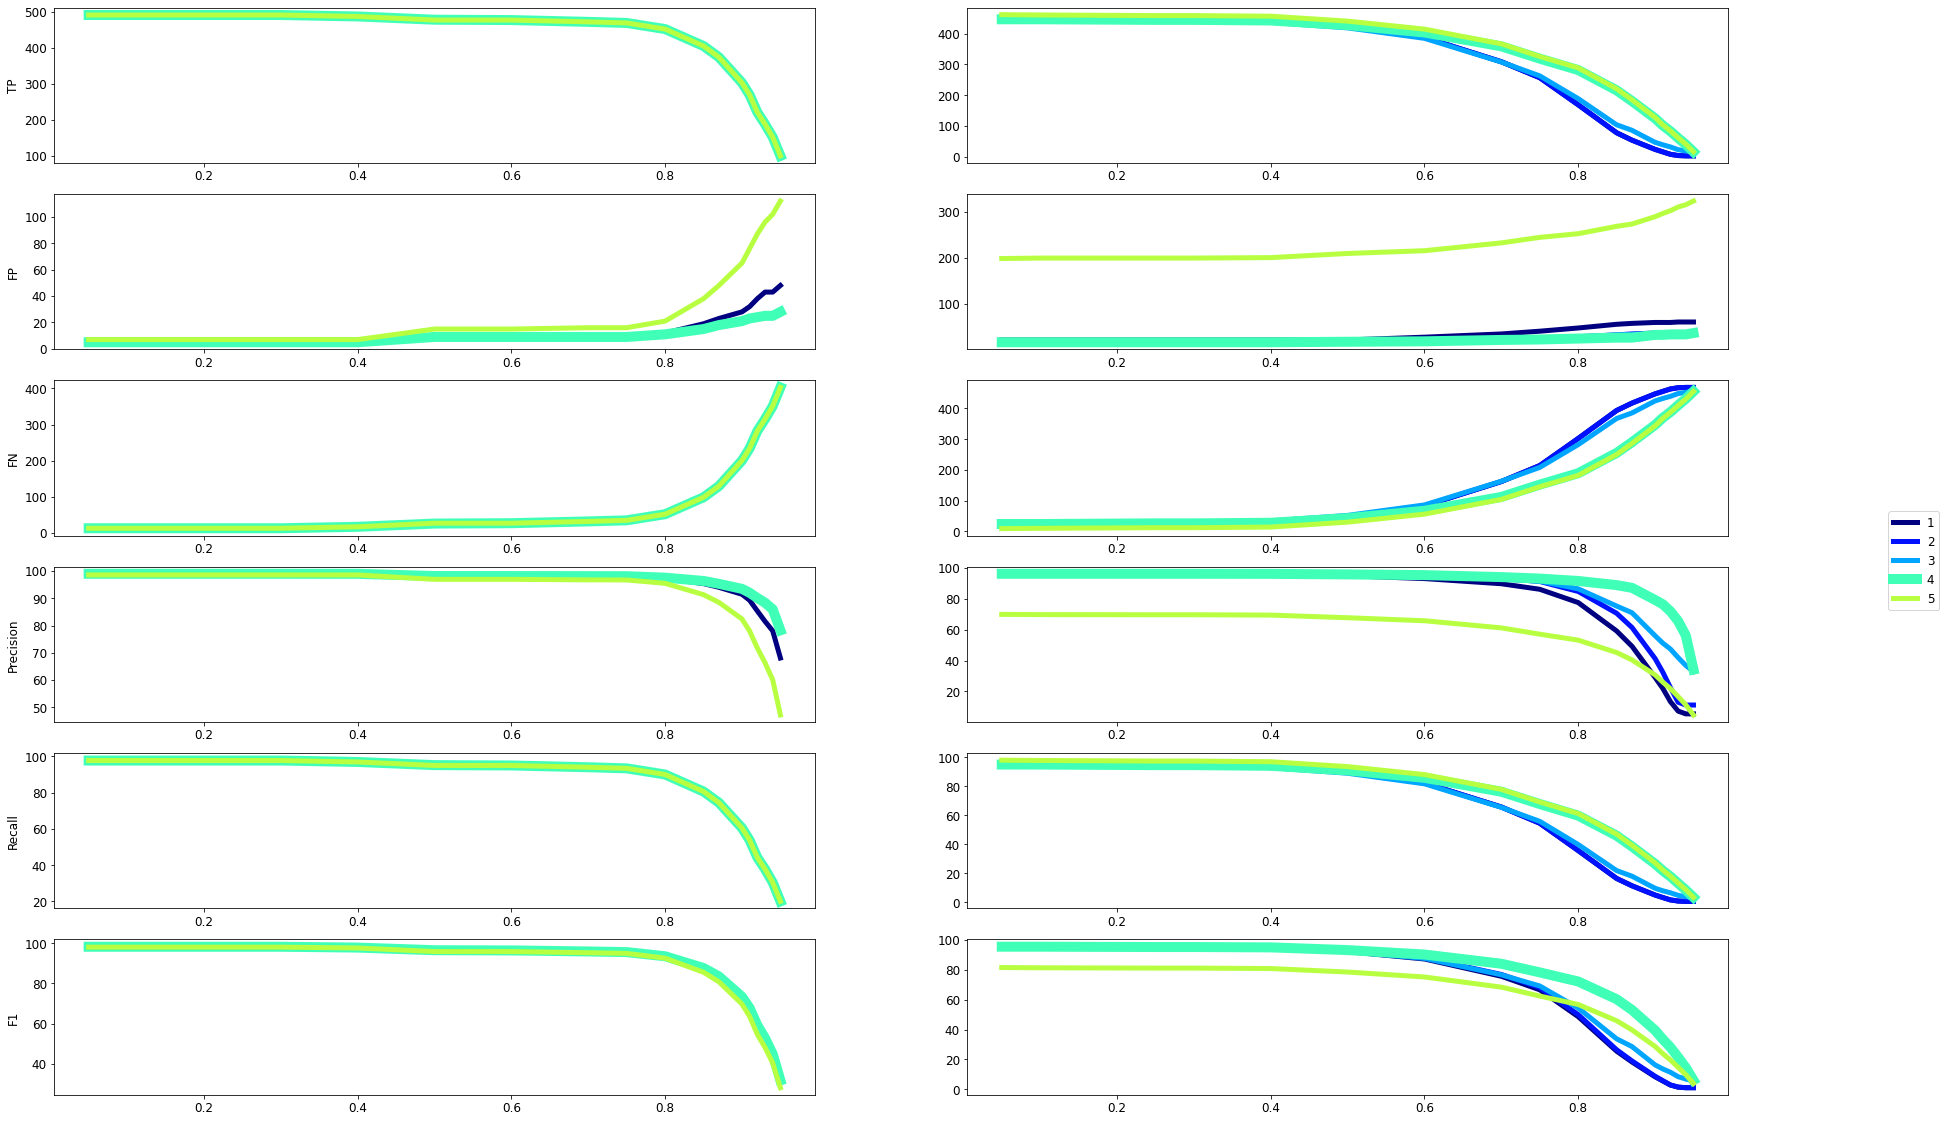

In [75]:
lw=5
fig, ax = plt.subplots(6,len(LABELS[:2]),figsize=(30,20))

for ip,(p,r,f,tp,fp,fn) in enumerate(zip(precsave,recsave,f1save,TPsave,FPsave,FNsave)):
    lwh=lw
    #lwh=5
    if ip==3: lwh=10
    #lwh = 8-ip
    for il in range(len(LABELS[:2])):
        ax[0][il].plot(iouvec2, tp[il],color=colors[ip],lw=lwh)
        ax[1][il].plot(iouvec2, fp[il],color=colors[ip],lw=lwh)
        ax[2][il].plot(iouvec2, fn[il],color=colors[ip],lw=lwh)
        if il == 0:
            ax[3][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
        else:
            ax[3][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
        ax[4][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
        ax[5][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)
        
for k in range(6): 
    ax[k][0].set_ylabel(ylabels[k])
    #for j in range(len(LABELS[:2])):
    #    ax[k][j].set_yscale('log')

fig.legend(loc='center right')
plt.show()

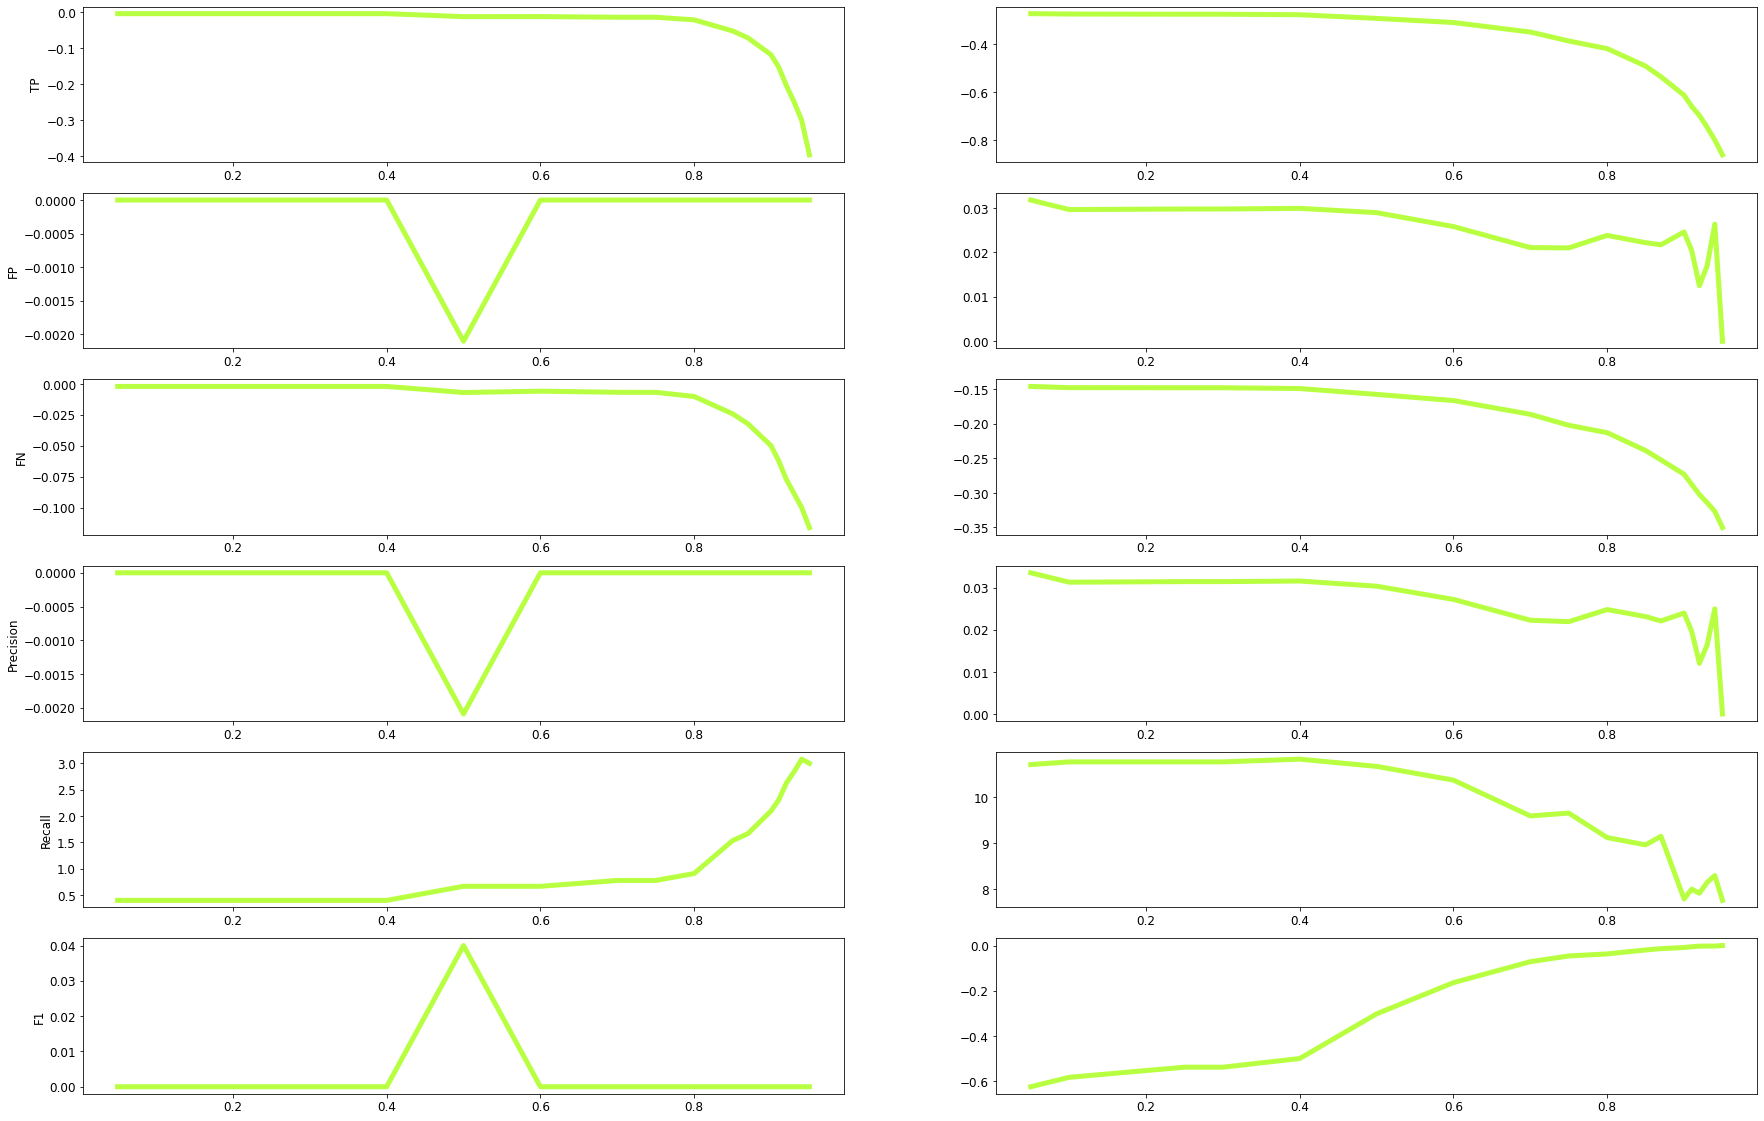

In [76]:
# plot ratio of last 2 changes
fig, ax = plt.subplots(6,len(LABELS[:2]),figsize=(30,20))
lwh=5
for il in range(len(LABELS[:2])):
    ax[0][il].plot(iouvec2, precsave[-1][il]/precsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[1][il].plot(iouvec2, recsave[-1][il]/recsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[2][il].plot(iouvec2, f1save[-1][il]/f1save[-2][il]-1,color=colors[ip],lw=lwh)
    ax[3][il].plot(iouvec2, TPsave[-1][il]/TPsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[4][il].plot(iouvec2, FPsave[-1][il]/FPsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[5][il].plot(iouvec2, FNsave[-1][il]/FNsave[-2][il]-1,color=colors[ip],lw=lwh)
        
for k in range(6): 
    ax[k][0].set_ylabel(ylabels[k])
    #for j in range(len(LABELS[:2])):
    #    ax[k][j].set_yscale('log')

plt.show()

In [81]:
for ibb,(b1,b2) in enumerate(zip(boxes_heur,boxes_heur2)):
    for bb1,bb2 in zip(b1,b2):
        if (bb1 != bb2).any():
            import sys; sys.exit()

SystemExit: 

In [82]:
b1,b2

(array([[ 70.64784241, 410.99636364, 444.24072266, 431.41091919],
        [125.86857605,  63.09107971, 512.        , 402.93823242]]),
 array([[ 70.64784241, 410.99636364, 444.24072266, 431.41091919],
        [125.86857605,  63.09107971, 546.0769043 , 402.93823242]]))

In [83]:
ibb

82

In [84]:
boxes_heur[82], boxes_heur2[82]

(array([[ 70.64784241, 410.99636364, 444.24072266, 431.41091919],
        [125.86857605,  63.09107971, 512.        , 402.93823242]]),
 array([[ 70.64784241, 410.99636364, 444.24072266, 431.41091919],
        [125.86857605,  63.09107971, 546.0769043 , 402.93823242]]))

In [85]:
captionText_figcap[82]

[[(448, 2662, 511, 2689, 'Fic.'),
  (535, 2661, 752, 2695, '1—Spectrum'),
  (772, 2660, 803, 2688, 'of'),
  (822, 2660, 921, 2688, 'V1057'),
  (942, 2659, 1038, 2694, 'Cygni'),
  (1056, 2659, 1145, 2688, 'taken'),
  (1165, 2668, 1204, 2688, 'on'),
  (1226, 2659, 1294, 2688, '1972'),
  (1315, 2659, 1392, 2693, 'June'),
  (1412, 2659, 1446, 2688, '27'),
  (1471, 2659, 1568, 2693, '(UT).'),
  (1589, 2659, 1652, 2687, 'The'),
  (1672, 2658, 1832, 2692, 'dispersion'),
  (1851, 2658, 1874, 2686, 'is'),
  (1896, 2659, 1929, 2686, '63'),
  (1950, 2653, 1976, 2685, 'A'),
  (1996, 2656, 2107, 2685, 'mm—1'),
  (411, 2700, 470, 2728, 'and'),
  (491, 2700, 540, 2728, 'the'),
  (563, 2700, 656, 2728, 'width'),
  (677, 2700, 699, 2727, 'is'),
  (720, 2701, 766, 2728, '0.6'),
  (787, 2708, 857, 2728, 'mm.'),
  (878, 2699, 941, 2727, 'The'),
  (961, 2701, 1110, 2733, 'spectrum'),
  (1130, 2699, 1154, 2726, 'is'),
  (1176, 2698, 1318, 2726, 'classified'),
  (1339, 2706, 1369, 2726, 'as'),
  (1392, 2698,

In [86]:
bbox_figcap_pars[82]

[(398, 2649, 2121, 2776, 0.0), (1478, 401, 1730, 444, 0.0)]

In [87]:
labels_heur[82], labels_heur2[82]

([1, 0], [1, 0])

In [88]:
from annotation_utils import get_all_ocr_files, collect_ocr_process_results, \
   get_makesense_info_and_years, get_years


/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /Users/jillnaiman/.config/yt/ytrc is deprecated in favor of /Users/jillnaiman/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [90]:
# let's get all of the ocr files
ocrFiles = get_all_ocr_files()
# get important quantities from these files
print('retreiving OCR data, this can take a moment...')
ws, paragraphs, squares, html, rotations = collect_ocr_process_results(ocrFiles)
# create dataframe
df = pd.DataFrame({'ws':ws, 'paragraphs':paragraphs, 'squares':squares, 
                   'hocr':html, 'rotation':rotations})#, 'pdfwords':pdfwords})
df = df.drop_duplicates(subset='ws')
df = df.set_index('ws')

dfMakeSense = get_makesense_info_and_years(df)


retreiving OCR data, this can take a moment...
--- OCR retrieval: on 0 of 5515
--- OCR retrieval: on 1000 of 5515
--- OCR retrieval: on 2000 of 5515
--- OCR retrieval: on 3000 of 5515
--- OCR retrieval: on 4000 of 5515
--- OCR retrieval: on 5000 of 5515
---- for some reason 1901ApJ____14__269C_p7 is not in this list -----
---- for some reason 1996ApJ___466_1087P_p8 is not in this list -----
---- for some reason 1979AJ_____84__910B_p10 is not in this list -----
---- for some reason 1989AJ_____98_1398H_p5 is not in this list -----
---- for some reason 1994ApJS___95__457W_p15 is not in this list -----
---- for some reason 1990ApJ___351__443U_p6 is not in this list -----
---- for some reason 1963ApJ___137__280W_p8 is not in this list -----
---- for some reason 1990ApJ___365__510C_p2 is not in this list -----
---- for some reason 1991ApJS___76__455E_p6 is not in this list -----
---- for some reason 1992AJ____103_1151C_p9 is not in this list -----
---- for some reason 1982ApJS___50____1W_p18

In [93]:
dfMakeSense.loc[82]

filename                               1979ApJ___231__673S_p1
squares     [(282, 428, 1965, 1961, figure), (265, 2402, 2...
w                                                        2550
h                                                        3300
Name: 82, dtype: object

In [94]:
ff = imgs_name[82].split('/')[-1].split('.npz')[0]
dfMS = dfMakeSense.loc[dfMakeSense['filename']==ff]


In [95]:
dfMS

,filename,squares,w,h
78,1972ApJ___177L__85S_p1,"[(765, 374, 999, 2208, figure), (374, 2641, 17...",2550,3300


In [96]:
fracx = dfMS['w'].values[0]*1.0/config.IMAGE_W
fracy = dfMS['h'].values[0]*1.0/config.IMAGE_H  
fracx,fracy

(4.98046875, 6.4453125)

In [107]:
from importlib import reload
import post_processing_utils
reload(post_processing_utils)

<module 'post_processing_utils' from '/Users/jillnaiman/figure_and_caption_extraction/post_processing_utils.py'>

In [108]:
from post_processing_utils import clean_merge_heurstic_captions

In [109]:
boxes_heur_here, labels_heur_here, scores_heur_here,\
  ibbOverlap_here = clean_merge_heurstic_captions(boxes_pdf[82], 
                                        labels_pdf[82], scores_pdf[82], 
                                        bbox_figcap_pars[82], LABELS,dfMS)

In [110]:
boxes_heur_here

array([[ 70.64784241, 410.99636364, 444.24072266, 431.41091919],
       [125.86857605,  63.09107971, 512.        , 402.93823242]])

In [100]:
boxes_heur2, labels_heur2, scores_heur2 = add_heuristic_captions(bbox_figcap_pars,
                                                              captionText_figcap,
                                                              ibbOverlap,
                                                              boxes_heur, 
                                                              labels_heur, 
                                                              scores_heur, dfMS)

array([[ 70.64784 , 411.2172  , 444.24072 , 431.41092 ],
       [125.868576,  63.09108 , 546.0769  , 402.93823 ]], dtype=float32)